In [1]:
%pylab inline
from __future__ import (division, print_function)

import os
import sys
import copy
import fnmatch
import warnings

# Numpy & Scipy
import scipy
import numpy as numpy 

# Astropy related
from astropy.io import fits 
from astropy import wcs
from astropy import units as u
from astropy.table import Table, Column, vstack
from astropy.stats import sigma_clip

# Matplotlib 
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator
# from astroML.plotting import hist
# plt.ioff()

# ColorMap
from palettable.colorbrewer.sequential import PuBu_5, OrRd_6
cmap1 = PuBu_5.mpl_colormap
cmap2 = OrRd_6.mpl_colormap

# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 1.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 1.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 1.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['legend.numpoints'] = 1
rc('axes', linewidth=2)

# Shapely related imports
from shapely.geometry import Polygon, LineString, Point
from shapely          import wkb
from shapely.ops      import cascaded_union
from shapely.prepared import prep
from descartes import PolygonPatch

Populating the interactive namespace from numpy and matplotlib


In [2]:
# SDSS pivot wavelength 
sdss_u_pivot = 3551.0
sdss_g_pivot = 4686.0
sdss_r_pivot = 6165.0
sdss_i_pivot = 7481.0
sdss_z_pivot = 8931.0

# GALEX pivot wavelength 
galex_fuv_pivot = 1535.0
galex_nuv_pivot = 2301.0

# WISE pivot wavelength 
wise_w1_pivot = 34000.0
wise_w2_pivot = 46000.0

# HSC pivot wavelength 
hsc_g_pivot = 4782.2
hsc_r_pivot = 6101.7 
hsc_i_pivot = 7648.0 
hsc_z_pivot = 8883.0
hsc_y_pivot = 9750.8

hscFiltWave = np.asarray([hsc_g_pivot, hsc_r_pivot, hsc_i_pivot, hsc_z_pivot, hsc_y_pivot])

In [3]:
def songPlotSetup(ax):
    """Setup the format of the figure."""
    # Axes setup
    #  Minor Ticks on 
    ax.minorticks_on()
    #  Axes Thickness
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(3.5)
    #  Tick Label Size 
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    
    #  Tick Length and Width
    ax.tick_params('both', length=10, width=3.0, which='major')
    ax.tick_params('both', length=6, width=2.5, which='minor')
    
    return ax

In [4]:
def removeIsNullCol(cat, output=None, catHdu=1, string='isnull'):
    """Remove the xxx_isnull columns from the catalog."""
    if not os.path.isfile(cat):
        raise Exception("Can not find catalog: %s" % cat)
        
    if output is None: 
        output = cat
        
    hdulist = fits.open(cat)
    colnames = hdulist[catHdu].columns.names 
    data = hdulist[catHdu].data
    
    for col in colnames:
        if string in col:
            data.columns.del_col(col)
            
    hdulist[catHdu].data = data 
    
    hdulist.writeto(output, clobber=True)

In [5]:
def polyReadWkb(wkbName, load=True):
    """Read a .wkb file into a Polygon shape."""
    wkbFile = open(wkbName, 'r')
    polyWkb = wkbFile.read().decode('hex')
    wkbFile.close()

    if load is True:
        return wkb.loads(polyWkb)
    else:
        return polyWkb

In [6]:
def hscFlux2AB(flux, zero=27.0): 
    """
    Convert HSC flux in unit of ADU to AB magnitude. 
    
    So far, constant zeropoint is applied to the calibration 
    """
    try: 
        mag = -2.5 * np.log10(flux) + zero
    except NameError: 
        import numpy as np 
        mag = -2.5 * np.log10(flux) + zero
    
    return mag


def hscMag2Flux(mag, unit='maggy'):
    """
    Convert HSC AB magnitude into physical flux. 
    
    Three units can be used here: 
    unit='maggy/nanomaggy/jy'
    """
    flux = 10.0 ** (-0.4 * mag) 
    
    if unit.lower().strip() == 'jy': 
        return (flux * 3631.0)
    elif unit.lower().strip() == 'maggy': 
        return flux 
    elif unit.lower().strip() == 'nanomaggy':
        return (flux * 1.0E-9)
    else: 
        raise Exception("## Wrong unit, should be jy/maggy/nanomaggy")
        
        
def hscMaggy2AB(flux):
    """
    Convert flux in unit of Maggies into AB magnitude
    """
    
    return (np.log10(flux) / -0.4)
        
    
def hscMaggyErr2ABErr(flux, fluxErr, ivar=False):
    """
    Convert (flux, fluxErr) into AB magnitude error 
    """
    
    if ivar: 
        fluxErr = np.sqrt(1.0 / fluxErr)
    
    return (2.5 * np.log10((flux + fluxErr) / flux))
    
    
def hscMagerr2Ivar(flux, magErr): 
    """
    Get the inverse variance of flux estimates from Flux and magErr 
    """
    
    fluxErr = flux * ((10.0 ** (magErr/2.5)) - 1.0)
    
    return (1.0 / (fluxErr ** 2.0))


def hscMagerr2Fluxerr(flux, magErr): 
    """
    Get the inverse variance of flux estimates from Flux and magErr 
    """
    
    fluxErr = flux * ((10.0 ** (magErr/2.5)) - 1.0)
    
    return fluxErr

def hscFluxSNR2Ivar(flux, snr): 
    """
    Estimate inverse variance of flux error using HSC flux and snr 
    """
    
    fluxErr = flux / snr 
    
    return (1.0 / (fluxErr ** 2.0))

In [11]:
def filterCatlog(inputCat, raCol, decCol, filtUse='I', 
                 regUse='g09', reject=True, polyDir='./',
                 returnMask=True):
    """Filter a catalog using accept and rejection mask."""
    if not os.path.isfile(inputCat):
        raise Exception("Can not find input catalog: %s" % s)

    inputData = Table.read(inputCat, format='fits')

    raArr, decArr = inputData[raCol].data, inputData[decCol].data
    print("Will deal with %d objects" % len(raArr))

    acpStr = acpFormat.replace('FILTER', filtUse)
    acpStr = acpStr.replace('REG', regUse)
    print("Filter through the accept mask: %s" % acpStr)
    acpMask = os.path.join(polyDir, acpStr)
    if not os.path.isfile(acpMask):
        raise Exception("Can not find accept mask: %s" % acpMask)
    acpRegs = polyReadWkb(acpMask)
    acpPrep = prep(acpRegs)
    inside = map(lambda x, y: acpPrep.contains(Point(x, y)), raArr, decArr)

    if reject:
        rejStr = rejFormat.replace('FILTER', filtUse)
        rejStr = rejStr.replace('REG', regUse)
        print("Filter through the reject mask: %s" % rejStr)
        rejMask = os.path.join(polyDir, rejStr)
        if not os.path.isfile(rejMask):
            raise Exception("Can not find reject mask: %s" % rejMask)
        rejRegs = polyReadWkb(rejMask)
        rejPrep = prep(rejRegs)
        masked = map(lambda x, y: rejPrep.contains(Point(x, y)), raArr, decArr)
        
        useful = map(lambda x, y: x and (not y), inside, masked)
    else:
        useful = inside
    
    if returnMask:
        return inputData[np.where(useful)], acpRegs, rejRegs
    else:
        return inputData[np.where(useful)]

In [13]:
def addMaggies(inputCat, magType='mag_cmodel', 
               snr=None, 
               filters=['g', 'r', 'i', 'z', 'y'],
               maggiesCol='cmodel_maggies', ivarsCol='cmodel_ivars',
               saveNew=True, outputCat=None, sortCol=None):
    """Convert the magnitude and error into Maggies and IvarMaggies."""
    if not os.path.isfile(inputCat):
        raise Exception("Can not find input catalog: %s" % s)
    
    data = Table.read(inputCat, format='fits')
    
    maggies = np.dstack((map(lambda f: hscMag2Flux(data[f + magType] - 
                                                   data['a_' + f], unit='maggy'), filters)))[0]

    if snr is None:
        ivars = np.dstack((map(lambda f: hscMagerr2Ivar(
                        hscMag2Flux(data[f + magType] - data['a_' + f], unit='maggy'), 
                        data[f + magType + '_err']), filters)))[0]
    else:
        ivars = np.dstack((map(lambda f: hscFluxSNR2Ivar(
                        hscMag2Flux(data[f + magType] - data['a_' + f], unit='maggy'), 
                        snr), filters)))[0]
        
    data.add_column(Column(name=maggiesCol, data=maggies))
    data.add_column(Column(name=ivarsCol, data=ivars))
                    
    if sortCol is not None:
        data.sort(sortCol)
                    
    if saveNew:
        if outputCat is None: 
            newCat = inputCat.replace('.fits', '_' + magType + '_maggies.fits')
        else:
            newCat = outputCat
        
        data.write(newCat, format='fits', overwrite=True)

    return data

# Selection of massive galaxies from the HSC S15B data release 


In [12]:
# Working directory 
dataDir = '/Users/songhuang/Downloads/dr15b'

galDir = os.path.join(dataDir, 'wide_galaxy')
galWide = 'dr1_gal21_cmodel_i.fits'

mosaicDir = os.path.join(dataDir, 'basic/mosaic')
mosaicPre = 's15b_wide_i_mosaic_REG.fits'

polyDir = os.path.join(dataDir, 'basic/polymask/wide')
acpFormat = 'dr1_wide_HSC-FILTER_patch_REG.wkb'
rejFormat = 'dr1_wide_HSC-FILTER_wkbBig_REG.wkb'

# Wide fields used: 
## GAMA09;  GAMA15;  WIDE12;  XMM-LSS;  HECTOMAP;  VVDS
fields = ['g09', 'g15', 'w12', 'xmm', 'hec', 'vvd']
filters = ['G', 'R', 'I', 'Z', 'Y']

# Spec-z catalog 
speczCat = os.path.join(dataDir, 'basic/specz/dr1_specz.fits')

# SDSS Master
sdssMaster = os.path.join(dataDir, 'sdss', 'sdss_dr12_i20.5_master.fits')
# GAMA Master 
gamaMaster = os.path.join(dataDir, 'gama', 'gama_dr2_master.fits')
# redMaPPer Master
redbcgMaster = os.path.join(dataDir, 'redmapper', 'redmapper_dr8_bcg_master.fits')
redmemMaster = os.path.join(dataDir, 'redmapper', 'redmapper_dr8_mem_master.fits')

In [79]:
inputCat = redbcgMaster 
raCol, decCol = 'ra_bcg_redm', 'dec_bcg_redm'
filtUse, regUse = 'I', 'g09'

test, acpG09I, rejG09I = filterCatlog(redbcgMaster, raCol, decCol, 
                                      filtUse=filtUse, regUse=regUse,
                                      reject=True, polyDir=polyDir)

Will deal with 26350 objects
Filter through the accept mask: dr1_wide_HSC-I_patch_g09.wkb
Filter through the reject mask: dr1_wide_HSC-I_wkbBig_g09.wkb


In [9]:
def showPolyMask(maskShow, ax):
    """Outline all the mask regions."""
    if maskShow.type is "Polygon":
        bounds = maskShow.boundary
        if bounds.type is "LineString":
            x, y = bounds.xy
            ax.plot(x, y, c='r', lw=2.0)
        elif bounds.type is "MultiLineString":
            for bb in bounds:
                x, y = bb.xy
                ax.plot(x, y, lw=2.0, color='r')
    elif maskShow.type is "MultiPolygon":
        for ii, mask in enumerate(maskShow):
            bounds = mask.boundary
            if bounds.type is "LineString":
                x, y = bounds.xy
                ax.plot(x, y, c='r', lw=1.5)
            elif bounds.type is "MultiLineString":
                for bb in bounds:
                    x, y = bb.xy
                    ax.plot(x, y, lw=1.5, color='r')
            else:
                print(" !!! Can not plot shape %d - %s !" % (ii, bounds.type))

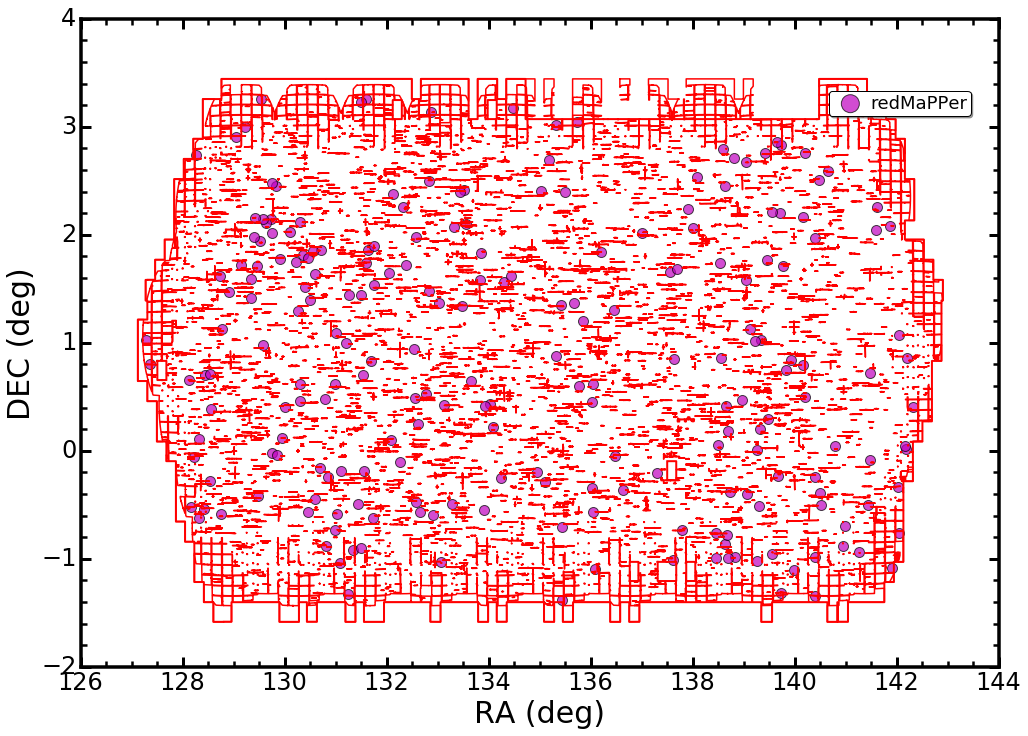

In [97]:
matchedCat = test
matchedLab = 'redMaPPer'
acpMask, rejMask = acpG09I, rejG09I

#---------------------------------------------------------#
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
# Formatting 
ax1 = songPlotSetup(ax1)

# RedMapper 
ax1.scatter(matchedCat[raCol], matchedCat[decCol], c='m', s=100, 
            alpha=0.7, label=matchedLab)

# Boundary 
showPolyMask(acpMask, ax1)
showPolyMask(rejMask, ax1)

# Label
ax1.set_xlabel('RA (deg)',  size=30)
ax1.set_ylabel('DEC (deg)', size=30)

# Axis limits
#ax1.set_xlim(129.3, 137.85)
#ax1.set_ylim(-0.95, 2.85)

# Title 
#ax1.text(136.7, 1.95, 'G09', size=45)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.815, 0.85),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=18, scatterpoints=1, 
           markerscale=1.8, borderpad=0.2, handletextpad=0.1)

#fig.savefig('hsc_gama_g09_match.png', dpi=90)

# Convert Magnitude into FLux and Flux Error 

In [77]:
bcgOld  = os.path.join(dataDir, 'dr15a', 'redbcg_1d_old.fits')

new = addMaggies(bcgOld, sortCol='z_use')